In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, confusion_matrix, auc
import optuna
from catboost import Pool, CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
import time

warnings.filterwarnings('ignore')

In [23]:
data = pd.read_csv('transactions')
data.head()

,Unnamed: 0,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


## Data prep

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                786363 non-null  int64  
 1   accountNumber             786363 non-null  int64  
 2   customerId                786363 non-null  int64  
 3   creditLimit               786363 non-null  int64  
 4   availableMoney            786363 non-null  float64
 5   transactionDateTime       786363 non-null  object 
 6   transactionAmount         786363 non-null  float64
 7   merchantName              786363 non-null  object 
 8   acqCountry                781801 non-null  object 
 9   merchantCountryCode       785639 non-null  object 
 10  posEntryMode              782309 non-null  float64
 11  posConditionCode          785954 non-null  float64
 12  merchantCategoryCode      786363 non-null  object 
 13  currentExpDate            786363 non-null  o

In [25]:
# Для всех строк дата-сета номер аккаунта совпадает id, один признак оставим для дальнейших агрегаций, второй можно удалить

len(data) == (data.accountNumber == data.customerId).sum()

True

In [26]:
# Удалим неинформативные признаки
zero_cols = ['accountNumber', 'echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd', 'Unnamed: 0']

data.drop(columns=zero_cols, inplace=True)
data.shape

(786363, 22)

In [27]:
# Приведем признаки к нужному формату: даты в datetime для будущих манипуляций, bool в числа

data['transactionDateTime'] = pd.to_datetime(data['transactionDateTime'])
data['accountOpenDate'] = pd.to_datetime(data['accountOpenDate'])
data['currentExpDate'] = pd.to_datetime(data['currentExpDate'])
data['dateOfLastAddressChange'] = pd.to_datetime(data['dateOfLastAddressChange'])

data['cardPresent'] = data['cardPresent'].astype(int)
data['expirationDateKeyInMatch'] = data['expirationDateKeyInMatch'].astype(int)
data['isFraud'] = data['isFraud'].astype(int)

In [28]:
print(data.transactionType.value_counts())
print(f'Пропущенных значений: {data.transactionType.isna().sum()}')

transactionType
PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: count, dtype: int64
Пропущенных значений: 698


In [29]:
# Заполню пропуски в типе транзакции значением 'Неизвестно'

data.transactionType.fillna('Unknown', inplace=True)

In [30]:
print(data.posConditionCode.value_counts())
print(f'Количество пропусков: {data.posConditionCode.isna().sum()}')

posConditionCode
1.0     628787
8.0     149634
99.0      7533
Name: count, dtype: int64
Количество пропусков: 409


In [31]:
# Заполню пропуск в этом признаке так же значением 'Неизвестно' и буду использовать его как категориальный, т.к. численной информации он не несет
# Это просто закодированное категориальное значение.

data.posConditionCode.fillna('Unknown', inplace=True)

In [32]:
# Так же поступим с posEntryMode

data.posEntryMode.fillna('Unknown', inplace=True)

In [33]:
# Процент совпадения кода эквайринга и кода мерчанта

((data.acqCountry == data.merchantCountryCode).sum()) / data.acqCountry.notna().sum()

0.9999104631485506

In [34]:
# В 99% случаев код совпадает, заполним пропуски в коде эквайринга на основе данных из признака кода мерчанта

data.loc[data.acqCountry.isna(), 'acqCountry'] = data['merchantCountryCode']

# Оценим процент пропусков после заполнения

print(f'Процент пропусков в коде эквайринга: {data.acqCountry.isna().sum() / len(data)}')
print(f'Процент пропусков в коде мерчанта: {data.merchantCountryCode.isna().sum() / len(data)}')

Процент пропусков в коде эквайринга: 0.0009168793547000558
Процент пропусков в коде мерчанта: 0.000920694386689099


In [35]:
# Оставшиеся пропуски так же заменим на значение 'Неизвестно'

data['acqCountry'].fillna('Unknown', inplace=True)
data['merchantCountryCode'].fillna('Unknown', inplace=True)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customerId                786363 non-null  int64         
 1   creditLimit               786363 non-null  int64         
 2   availableMoney            786363 non-null  float64       
 3   transactionDateTime       786363 non-null  datetime64[ns]
 4   transactionAmount         786363 non-null  float64       
 5   merchantName              786363 non-null  object        
 6   acqCountry                786363 non-null  object        
 7   merchantCountryCode       786363 non-null  object        
 8   posEntryMode              786363 non-null  object        
 9   posConditionCode          786363 non-null  object        
 10  merchantCategoryCode      786363 non-null  object        
 11  currentExpDate            786363 non-null  datetime64[ns]
 12  ac

Сохраним имена категориальных признаков в переменную для дальнейшего использования. 

In [37]:
category_features = list(data.select_dtypes(include=['object']).columns)
category_features

['merchantName',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'transactionType']

## Feature engineering

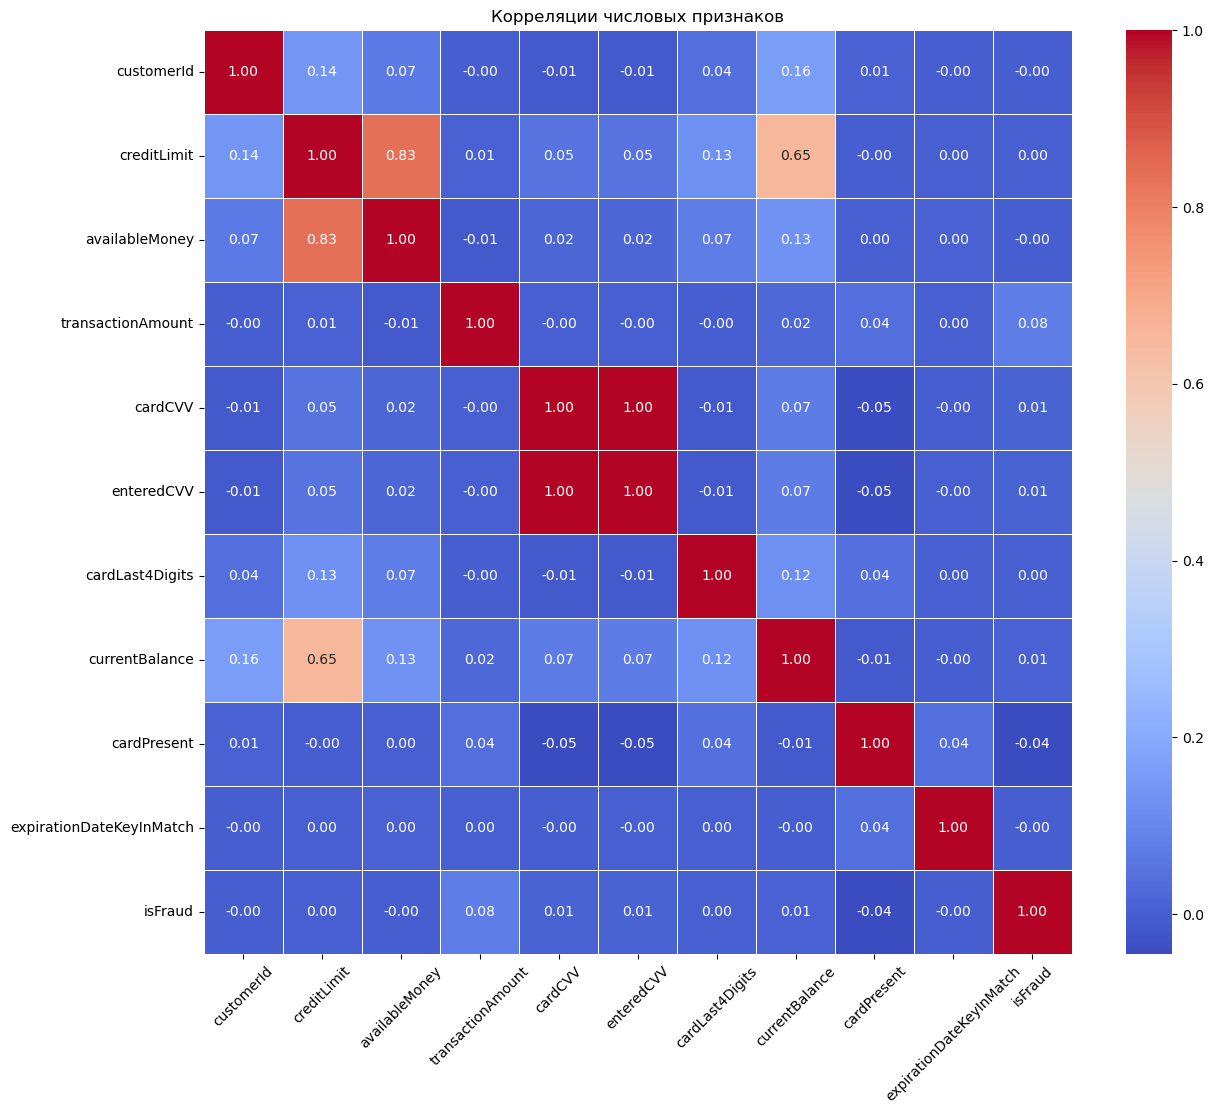

In [38]:
plt.figure(figsize=(14,12))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Корреляции числовых признаков")
plt.xticks(rotation=45);

In [39]:
# Проверим наличие несовпадений при вводе CVV при подтверждении транзакции

len(data) == (data.cardCVV == data.enteredCVV).sum()

False

In [40]:
# Создам бинарный признак, указывающий на верный ввод CVV кода

data['cvv_match'] = (data['cardCVV'] == data['enteredCVV']).astype(int)

In [41]:
# Извлечем временные признаки 
data['transaction_hour'] = data['transactionDateTime'].dt.hour                         # Час, в котором совершалась транзакция 
data['transaction_day'] = data['transactionDateTime'].dt.day                           # День месяца
data['transaction_weekday'] = data['transactionDateTime'].dt.weekday                   # День недели (0-6)
data['night_time'] = data['transaction_hour'].apply(lambda x: 1 if 0 <= x < 6 else 0)  # Ночные транзакции
data['is_weekend'] = (data['transaction_weekday'] >= 5).astype(int)                    # Совершена ли транзакция в выходной день

data['second_addres_change'] = (data['dateOfLastAddressChange'] > data['accountOpenDate']).astype(int)      # Замена адреса не в день открытия аккаунта
data['days_since_address_change'] = (data['transactionDateTime'] - data['dateOfLastAddressChange']).dt.days # Кол-во дней от замены адреса до транзакции


# Агрегация
data['avg_transaction_amount'] = data.groupby('customerId')['transactionAmount'].transform('mean').astype(int) # Средняя сумма транзакции
data['avg_transaction_hour'] = data.groupby('customerId')['transaction_hour'].transform('mean')                # Типичное время транзакции
data['diff_between_transactions'] = round((data.groupby('customerId')['transactionDateTime'].diff().dt.seconds / 3600), 1) # Разница между двумя транзакциями
data['diff_between_transactions'].fillna(data['diff_between_transactions'].median(), inplace=True) # Первую транзакцию заполним медианой, для большей чувствительности к маленьким интервалам

data['amount_deviation'] = data['transactionAmount'] - data['avg_transaction_amount']   # Отклонение суммы транзакции от средней
data['hour_deviation'] = abs(data['transaction_hour'] - data['avg_transaction_hour'])   # Отклонение времени транзакции от типичного

In [42]:
datetime_cols = list(data.select_dtypes('datetime64[ns]').columns)
cols_to_drop = datetime_cols + ['customerId']

data.drop(columns=cols_to_drop, inplace=True)
data.shape

(786363, 30)

## Training

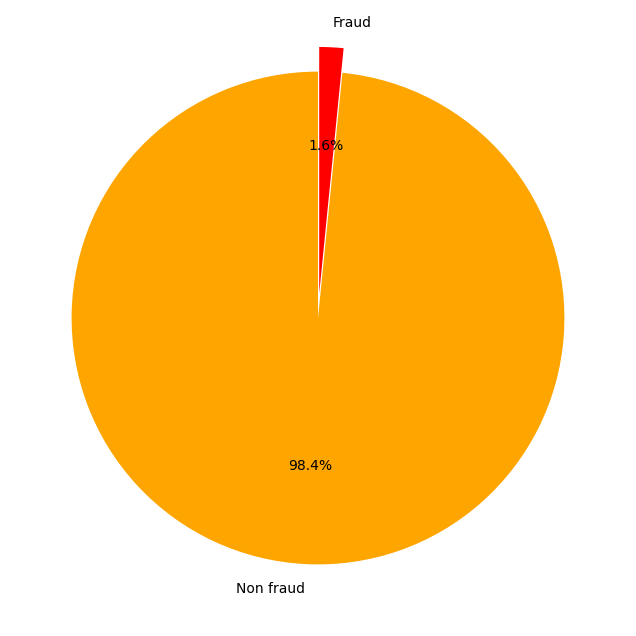

In [43]:
plt.figure(figsize=(8, 8))
plt.pie(x=data.isFraud.value_counts(),
       labels=['Non fraud', 'Fraud'],
       colors=['orange', 'red'],
       autopct='%1.1f%%',
       startangle=90,
       explode=[0, 0.1]
       );  # Ожидаемый бисбаланс классов

In [44]:
x = data.drop(columns=['isFraud'])
y = data['isFraud']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4, stratify=y)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

isFraud
0    0.984209
1    0.015791
Name: proportion, dtype: float64
isFraud
0    0.984212
1    0.015788
Name: proportion, dtype: float64


In [48]:
for col in category_features:
    x_train[col] = x_train[col].astype(str)

In [ ]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=4)

weight = (data['isFraud'] == 0).sum() / (data['isFraud'] == 1).sum()


def optuna_search(trial):
    params = {
    'depth': trial.suggest_int('depth', 3, 8),
    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
    'iterations': trial.suggest_int('iterations', 100, 500),
    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 3, log=True),
    'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, weight)
    }

    model = CatBoostClassifier(**params, cat_features=category_features, thread_count=2, verbose=0)

    score = cross_val_score(model, x_train, y_train, cv=cv, scoring='f1').mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(optuna_search, n_trials=50, n_jobs=6)

In [51]:
params = study.best_params

print(params)
print(study.best_value)

{'depth': 6, 'learning_rate': 0.17334142260251068, 'iterations': 320, 'l2_leaf_reg': 0.4952250667798186, 'scale_pos_weight': 4.692251987253448}
0.2517291738934091


In [52]:
cb = CatBoostClassifier(**params, cat_features=category_features, verbose=0)

train_pool = Pool(x_train, y_train, cat_features=category_features)

cb.fit(train_pool)

In [ ]:
for col in category_features:
    x_test[col] = x_test[col].astype(str)

test_pool = Pool(data=x_test, cat_features=category_features)

predict = cb.predict(test_pool)
probs = cb.predict_proba(test_pool)[:, 1]

In [106]:
def show_metrics(y_test, class_pred, probs):
    
    precision, recall, _ = precision_recall_curve(y_test, probs)

    print(f'precision: {precision_score(y_test, class_pred)}')
    print(f'recall: {recall_score(y_test, class_pred)}')
    print(f'f1: {f1_score(y_test, class_pred)}')
    print(f'roc-auc: {roc_auc_score(y_test, probs)}')
    print(f'pr-auc: {auc(recall, precision)}')
    print()
    print(confusion_matrix(y_test, predict))

show_metrics(y_test, predict, probs)

precision: 0.6545698924731183
recall: 0.19613370922271445
f1: 0.3018283235202975
roc-auc: 0.8389805584623153
pr-auc: 0.28007497962559524

[[154533    257]
 [  1996    487]]


In [73]:
feature_imp = {feature: imp for feature, imp in zip(list(x_test.columns), cb.get_feature_importance())}
feature_dict = dict(sorted(feature_imp.items(), key=lambda x: x[1], reverse=True))
feature_dict

{'avg_transaction_amount': 13.106621438628354,
 'merchantName': 12.744041685242578,
 'merchantCategoryCode': 11.098588148615082,
 'avg_transaction_hour': 8.68132631156625,
 'cardLast4Digits': 7.991477248482135,
 'transactionAmount': 7.027302580230924,
 'posEntryMode': 5.431115771219917,
 'enteredCVV': 3.914223530888663,
 'amount_deviation': 3.8284525053267475,
 'cardPresent': 3.7419381575014534,
 'cardCVV': 3.7257124598758864,
 'days_since_address_change': 3.2448168734642757,
 'creditLimit': 2.945448523593766,
 'currentBalance': 2.0443176535503786,
 'diff_between_transactions': 1.9626857587746942,
 'hour_deviation': 1.8840318602691113,
 'availableMoney': 1.8556535073634552,
 'transaction_hour': 1.2689484287614705,
 'transaction_day': 0.8392095117332768,
 'posConditionCode': 0.7938508713879008,
 'transaction_weekday': 0.5665918595676325,
 'cvv_match': 0.42454531548787267,
 'merchantCountryCode': 0.2961823666950473,
 'acqCountry': 0.2299862890060074,
 'transactionType': 0.211853627104644

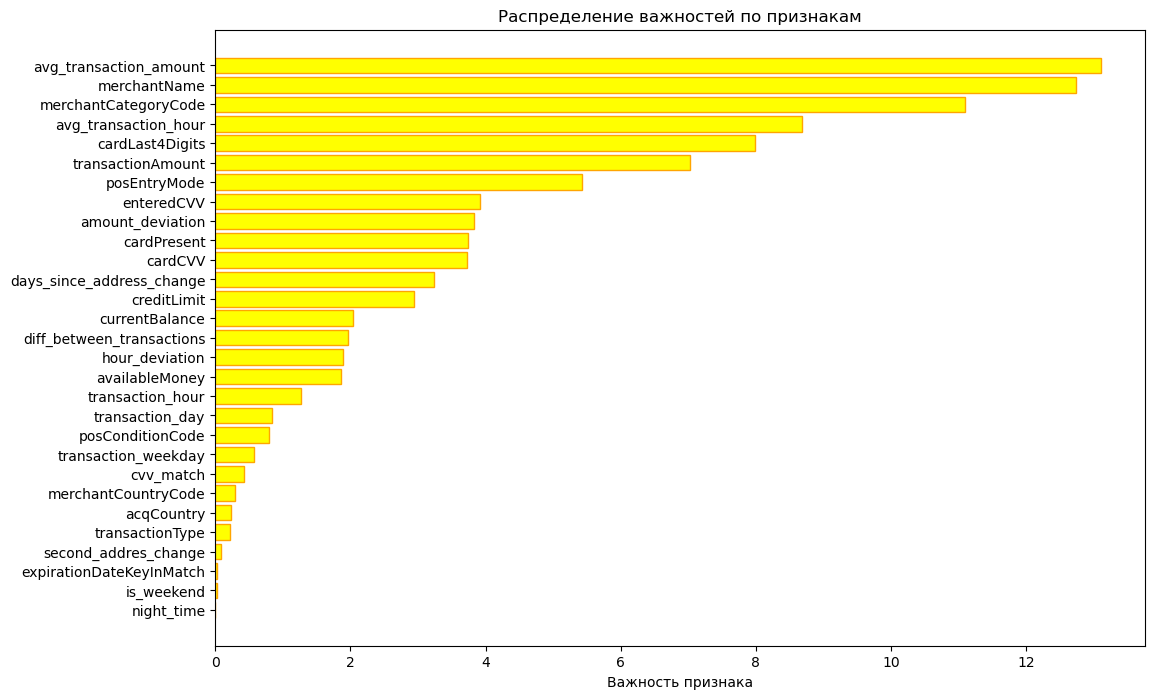

In [84]:
plt.figure(figsize=(12, 8))
plt.barh(list(feature_dict.keys()), list(feature_dict.values()), color='yellow', edgecolor='orange')
plt.gca().invert_yaxis()
plt.xlabel('Важность признака')
plt.title('Распределение важностей по признакам');

In [88]:
# Вычисляем shap-значения

explainer = shap.TreeExplainer(cb)
shap_values = explainer.shap_values(x_train)

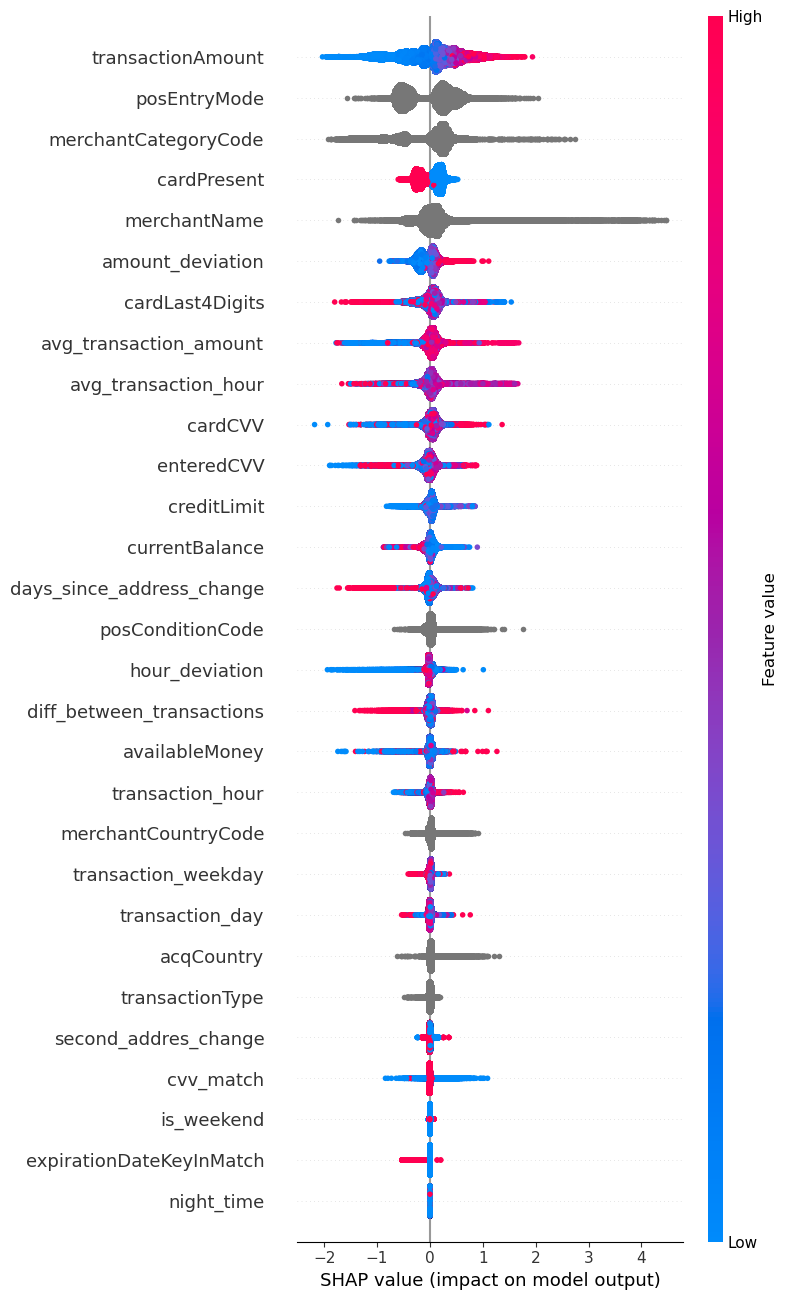

In [93]:
# Дополнительно оценим важность признаков с помощью библиотеки shap

shap.summary_plot(shap_values, x_train, max_display=len(x_train))

In [94]:
# Отсортированные признаки по абсолютному shap значению.

shap_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': x_train.columns,
    'shap_importance': shap_importance
}).sort_values(by='shap_importance',ascending=False)

importance_df

                      feature  shap_importance
2           transactionAmount         0.423580
6                posEntryMode         0.394207
8        merchantCategoryCode         0.337141
14                cardPresent         0.184354
3                merchantName         0.171023
27           amount_deviation         0.130471
11            cardLast4Digits         0.126689
24     avg_transaction_amount         0.116303
25       avg_transaction_hour         0.093322
9                     cardCVV         0.086916
10                 enteredCVV         0.081716
0                 creditLimit         0.060965
13             currentBalance         0.059208
23  days_since_address_change         0.058441
7            posConditionCode         0.041482
28             hour_deviation         0.037573
26  diff_between_transactions         0.034978
1              availableMoney         0.028576
17           transaction_hour         0.027575
5         merchantCountryCode         0.021315
19        tra

In [104]:
# Уберем из обучающих данных 4 признака, который в обоих случаях не имеют предсказательной силы и проверим после этого метрики

not_imp_features = ['night_time', 'is_weekend', 'expirationDateKeyInMatch', 'second_addres_change']

# Обновим список категориальных фичей, если некоторые из них оказались в not_imp_features
new_category_features = [f for f in category_features if f not in not_imp_features] 

updated_x_train = x_train.drop(columns=not_imp_features)
updated_x_test = x_test.drop(columns=not_imp_features)

upd_train_pool = Pool(updated_x_train, y_train, cat_features=new_category_features)
upd_test_pool = Pool(data=updated_x_test, cat_features=new_category_features)

cb2 = CatBoostClassifier(**params, cat_features=new_category_features, verbose=0)
start_train_time = time.time()
cb2.fit(upd_train_pool)
finish_train_time = time.time()

print(f'Время обучения составило: {(finish_train_time - start_train_time) / 60:.2f} минут')

start_pred_time = time.time()
predict2 = cb2.predict(upd_test_pool)
finish_pred_time = time.time()
probs2 = cb2.predict_proba(upd_test_pool)[:, 1]

print(f'Время предсказания составило: {(finish_pred_time - start_pred_time) / 60:.2f} минут')

Время обучения составило: 3.75 минут
Время предсказания составило: 0.01 минут


In [107]:
show_metrics(y_test, predict2, probs2)

precision: 0.6406460296096904
recall: 0.19170358437374144
f1: 0.29510229386236825
roc-auc: 0.8406057398072251
pr-auc: 0.2785245794373602

[[154533    257]
 [  1996    487]]


После удаления все метрики кроме roc-auc немного упали, поэтому сохраним модель, которая обучалась на всех данных. 

In [108]:
cb.save_model('catboost_model.cbm')

## Finances

In [114]:
tp_mask = (y_test == 1) & (predict == 1)
fp_mask = (y_test == 0) & (predict == 1)
fn_mask = (y_test == 1) & (predict == 0)
tn_mask = (y_test == 0) & (predict == 0)

print(confusion_matrix(y_test, predict))
print(f'True positive: {tp_mask.sum()}')
print(f'False positive: {fp_mask.sum()}')
print(f'False negative: {fn_mask.sum()}')
print(f'True negative: {tn_mask.sum()}')

[[154533    257]
 [  1996    487]]
True positive: 487
False positive: 257
False negative: 1996
True negative: 154533


Отразим предотвращенные мошеннические транзакции, пропущенные, ложные срабатывания в деньгах.

In [123]:
tp_amount = x_test.loc[tp_mask, 'transactionAmount'].sum()
fp_amount = x_test.loc[fp_mask, 'transactionAmount'].sum()
fn_amount = x_test.loc[fn_mask, 'transactionAmount'].sum()
tn_amount = x_test.loc[tn_mask, 'transactionAmount'].sum()

print(f'Предотвращено мошеннических транзакций на сумму: {tp_amount}')
print(f'Было ложно определено мошеннических транзакций на сумму: {fp_amount}')
print(f'Сумма пропущенных мошеннических транзакций: {fn_amount}')
print(f'Общая сумма мошеннических транзакций: {x_test.loc[y_test == 1, 'transactionAmount'].sum()}')
print(f'Сумма всех транзакций: {x_test.loc[:, 'transactionAmount'].sum()}')

Предотвращено мошеннических транзакций на сумму: 101790.0
Было ложно определено мошеннических транзакций на сумму: 90569.93
Сумма пропущенных мошеннических транзакций: 450920.80000000005
Общая сумма мошеннических транзакций: 552710.8
Сумма всех транзакций: 21528744.75


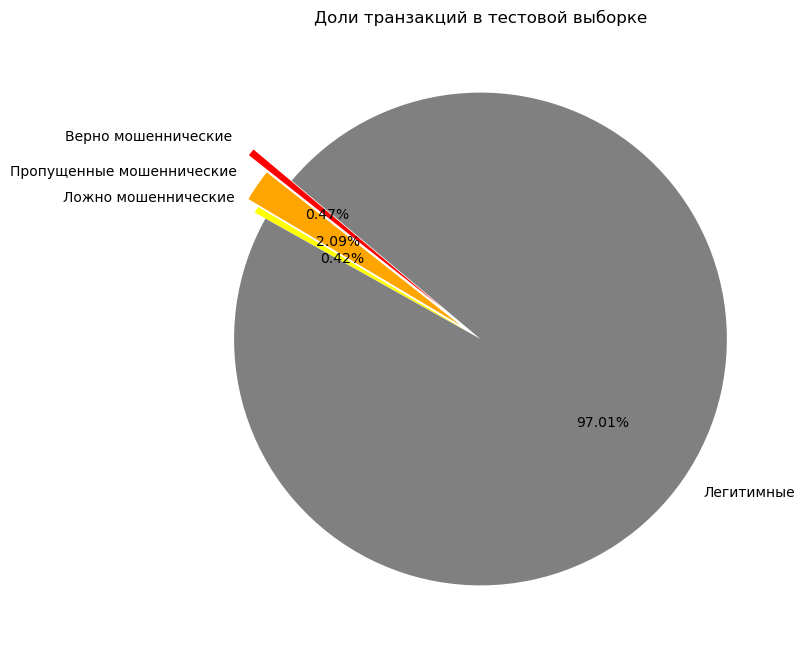

In [132]:
labels = ['Верно мошеннические', 'Пропущенные мошеннические', 
          'Ложно мошеннические', 'Легитимные']

plt.figure(figsize=(8, 8))
plt.pie([tp_amount, fn_amount, fp_amount, tn_amount],
        explode=(0.2, 0.1, 0.05, 0),
        labels=labels, 
        colors=['red', 'orange', 'yellow', 'gray'], 
        autopct='%1.2f%%', 
        startangle=140)
plt.title('Доли транзакций в тестовой выборке');